# Visualize 3D models with spateo

## Import packages

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Load data

In [2]:
adata = st.drosophila(url="https://www.dropbox.com/s/bvstb3en5kc6wui/E7-9h_cellbin_tdr_v2.h5ad?dl=0")

# pc model and mesh model are reconstructed by ``2.three dims models reconstruction``
pc_model = st.tdr.read_model(filename=f"embryo_pc_model.vtk")
mesh_model = st.tdr.read_model(filename=f"embryo_mesh_model.vtk")

# cpo
cpo = [(553.2878243418567, 1098.4674808068507, 277.4399476053088),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

## Visualize all slices that make up a 3D model in 2D

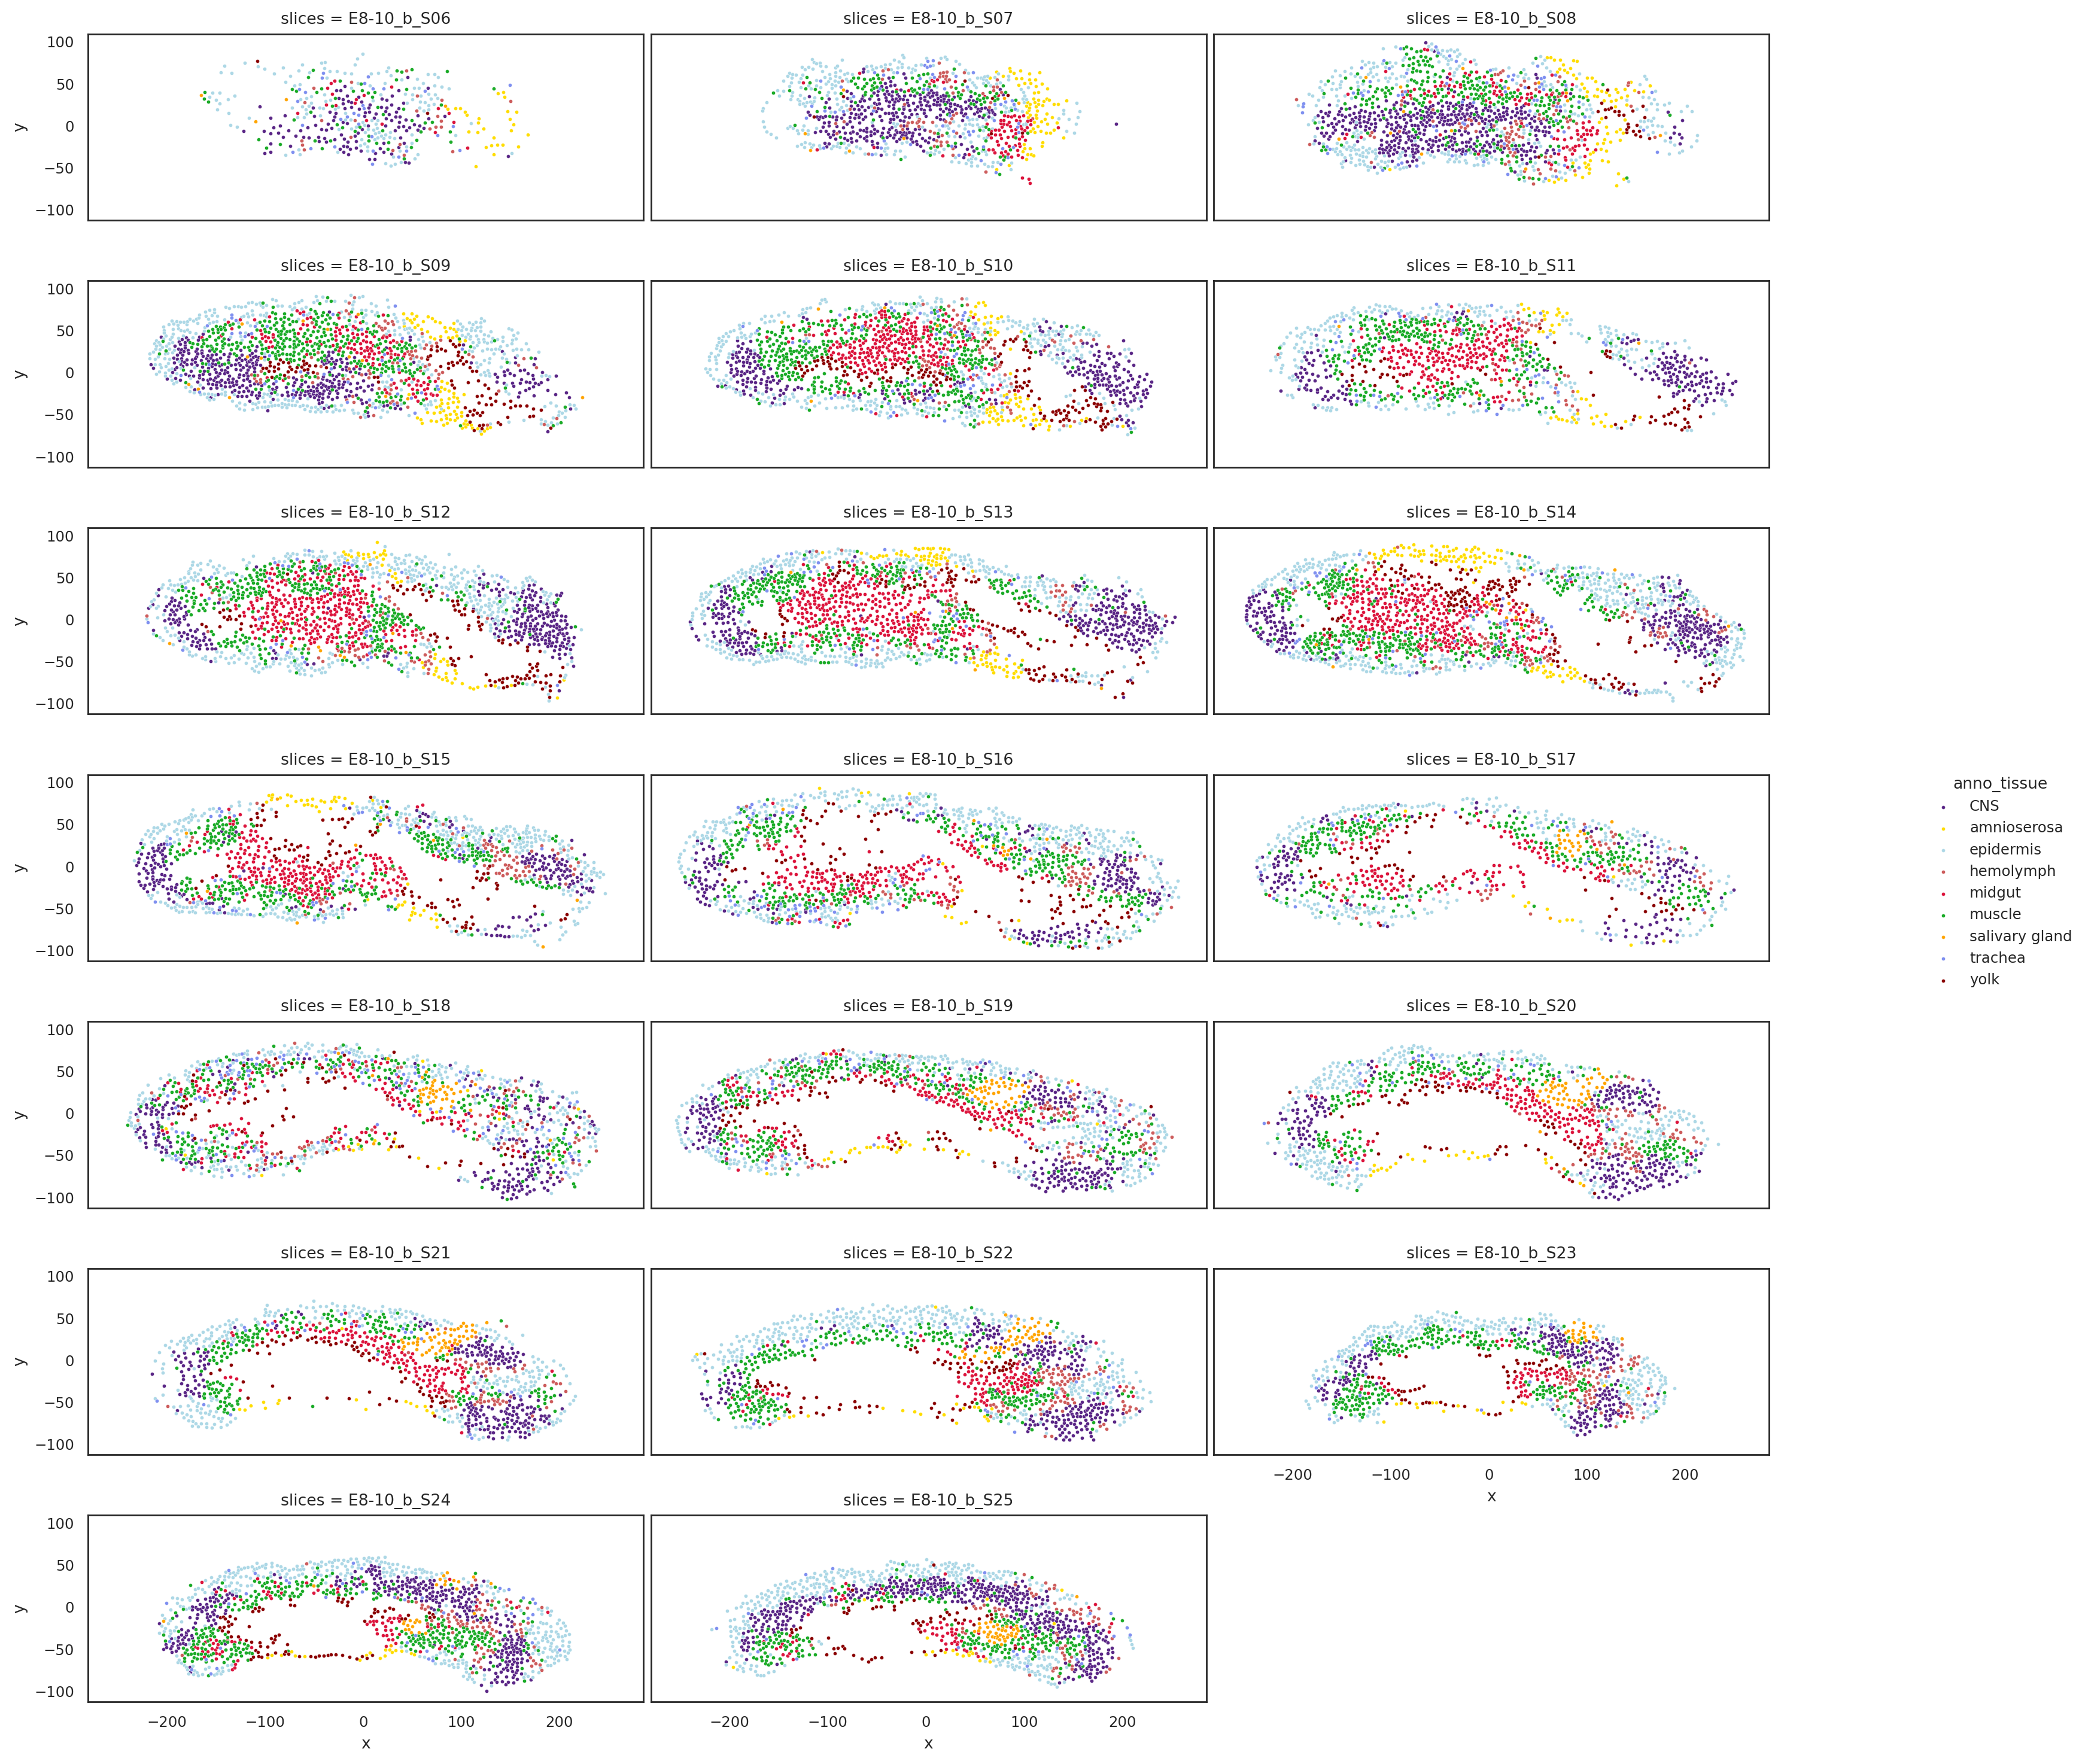

In [5]:
tissue_colormap = {
    "CNS": "#5A2686",
    "midgut": "#DC143C",
    "amnioserosa": "#FFDD00",
    "salivary gland": "#FFA500",

    "epidermis": "#ADD8E6",
    "muscle": "#1AAB27",
    "trachea": "#7F90F0",
    "hemolymph": "#CD5C5C",
    "yolk": "#8B0000",
}

st.pl.multi_slices(
    slices=adata.copy(),
    slices_key="slices",
    spatial_key="3d_align_spatial",
    label="anno_tissue",
    color=None,
    ax_height=0.15,
    palette=tissue_colormap,
    ncols=3,
    point_size=5,
    font_size=5,
    save_show_or_return="show",
)

## Visualize 3D models with tissue types result

### Visualize different 3D models separately

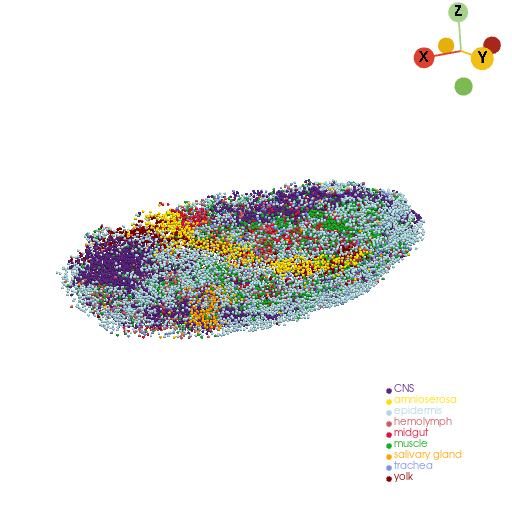

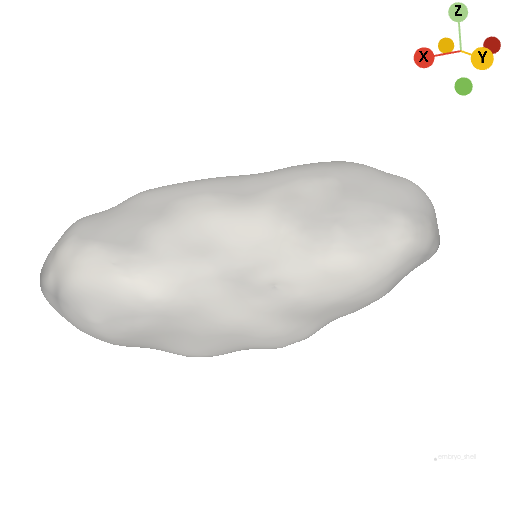

In [6]:
st.pl.three_d_plot(model=pc_model, key="tissue", model_style="points", jupyter="static", window_size=(512, 512), cpo=cpo)
st.pl.three_d_plot(model=mesh_model, key="tissue", model_style="surface", jupyter="static", window_size=(512, 512), cpo=cpo)

### Visualize integrated 3D models

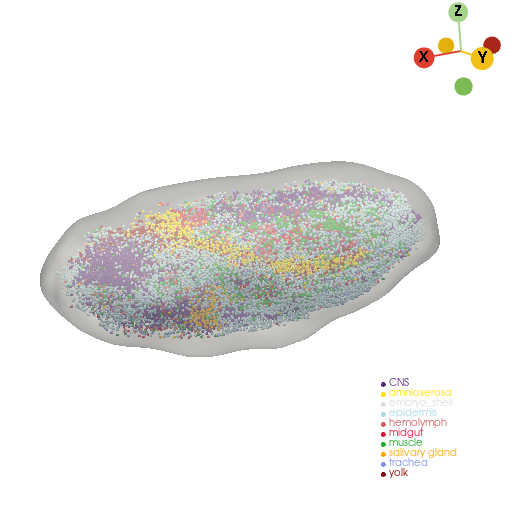

In [7]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([pc_model, mesh_model]),
    key="tissue",
    model_style=["points", "surface"],
    jupyter="static",
    window_size=(512, 512),
    cpo=cpo
)

### Visualize all models separately in a figure

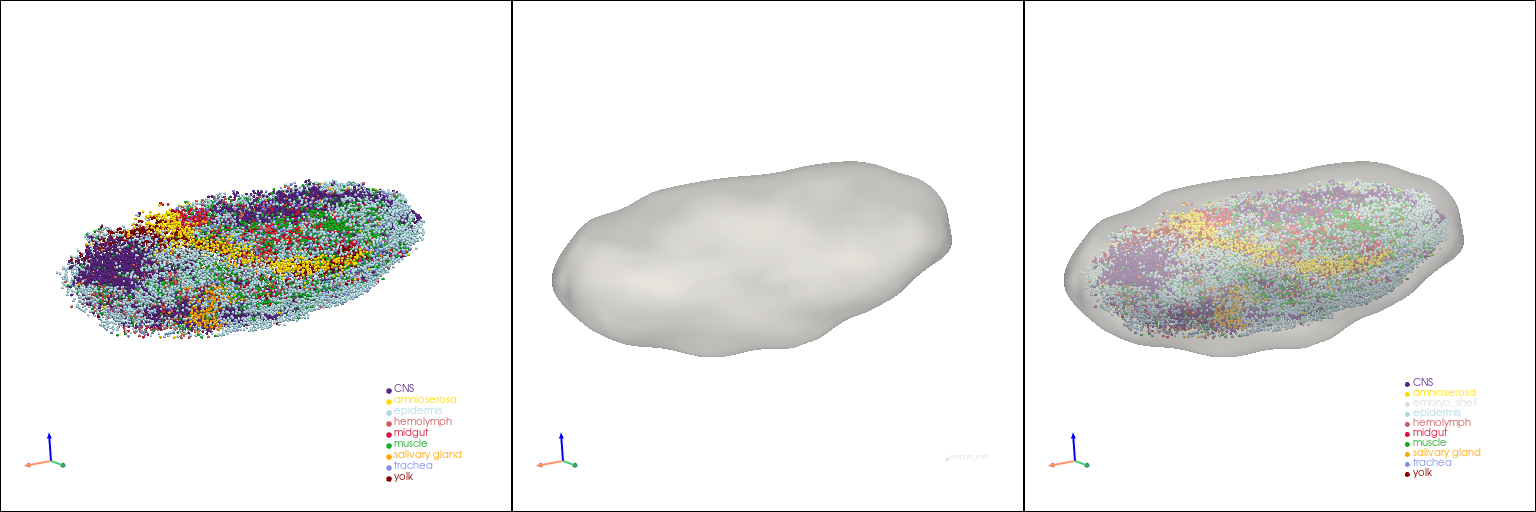

In [8]:
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(
        [
            pc_model,
            mesh_model,
            st.tdr.collect_models([pc_model, mesh_model]),
        ]
    ),
    key="tissue",
    model_style=["points", "surface", ["points", "surface"]],
    model_size=3,
    shape=(1, 3),
    window_size=(512*3, 512 * 1),
    jupyter="static",
    cpo=[cpo],
)

## Visualize point cloud model with gene expression

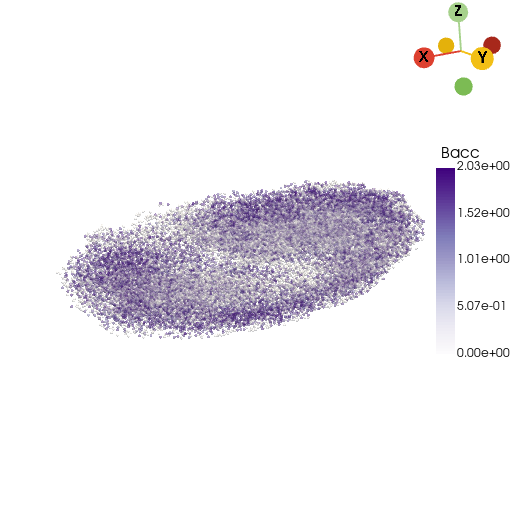

In [9]:
gene_name = "Bacc"

obs_index=pc_model.point_data["obs_index"].tolist()
exp = adata[obs_index, gene_name].layers["log1p_X"].flatten()
st.tdr.add_model_labels(model=pc_model, labels=exp, key_added=gene_name, where="point_data",inplace=True)
st.pl.three_d_plot(
    model=pc_model,
    key=gene_name,
    colormap="Purples",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    window_size=(512, 512),
    cpo=cpo
)

## Visualize voxel model with gene expression

In [10]:
voxel_model = st.tdr.voxelize_mesh(mesh=mesh_model, voxel_pc=None, key_added="tissue", label="voxel model", color="gainsboro", smooth=500)

In [11]:
kernel_interp_adata = st.tdr.kernel_interpolation(
    adata=adata[obs_index, :].copy(),
    genes=[gene_name],
    X=adata.obsm['3d_align_spatial'].astype(np.float64),
    Y=np.asarray(adata[obs_index, [gene_name]].layers["log1p_X"].astype(np.float32)),
    NX=np.asarray(voxel_model.points),
)
st.tdr.add_model_labels(model=voxel_model, labels=kernel_interp_adata[:, gene_name].X.flatten(), key_added=gene_name, where="point_data",inplace=True)

|-----> Learn a continuous mapping from space to gene expression pattern
|-----> Generate grid...
|-----> Creating a Convex Hull...
|-----> Identify grid points within the Convex Hull...
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [7.6555s]
|-----> Creating an adata object with the interpolated expression...
|-----> [KernelInterpolation] in progress: 100.0000%
|-----> [KernelInterpolation] finished [301.4068s]


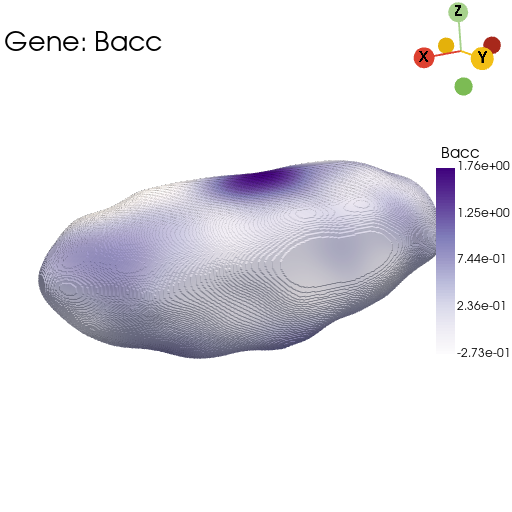

In [12]:
st.pl.three_d_plot(
    model=voxel_model,
    key=gene_name,
    colormap="Purples",
    ambient=0.2,
    model_style="surface",
    text=f"\nGene: {gene_name}",
    text_kwargs={"text_size": 15, "text_font": "arial"},
    jupyter="static",
    show_legend=True,
    window_size=(512, 512),
    cpo=cpo
)

### Visualize new slices generated by the voxel model

In [13]:
voxel_slices_x = st.tdr.three_d_slice(model=voxel_model, method="axis", n_slices=15, axis="x")
voxel_slices_y = st.tdr.three_d_slice(model=voxel_model, method="axis", n_slices=15, axis="y")
voxel_slices_z = st.tdr.three_d_slice(model=voxel_model, method="axis", n_slices=15, axis="z")

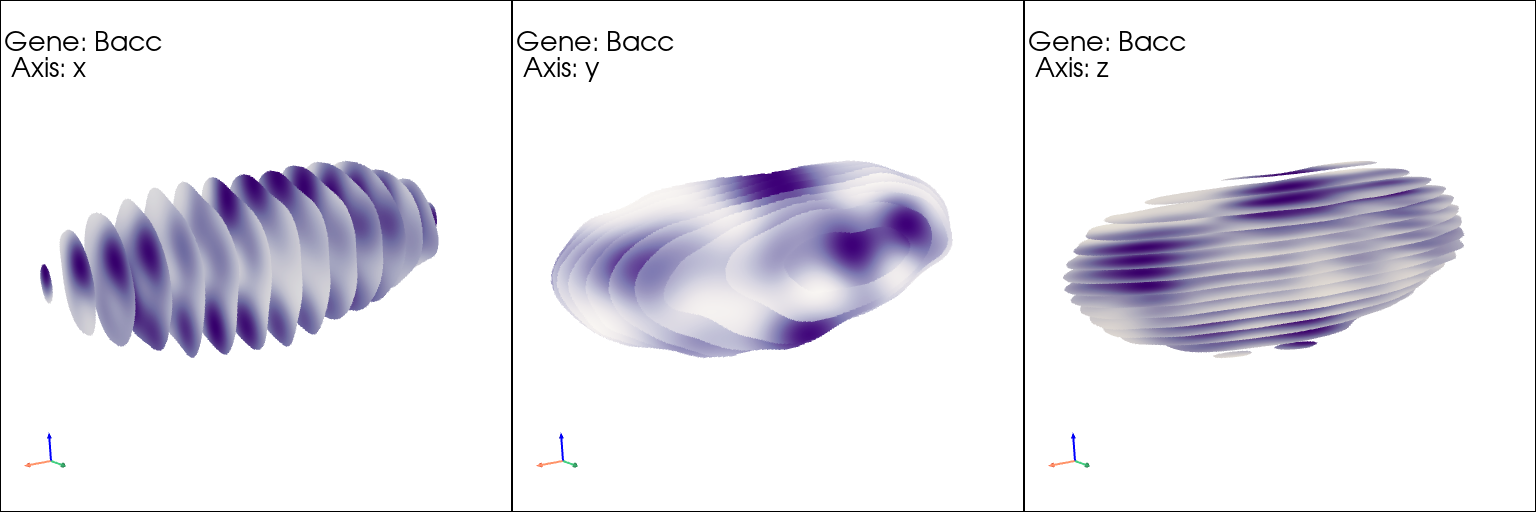

In [15]:
slices_models = [voxel_slices_x, voxel_slices_y, voxel_slices_z]
slices_axis = ["x", "y", "z"]
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(slices_models),
    key=gene_name,
    model_style="surface",
    colormap="Purples",
    ambient=[0.5, 0.3, 0.2],
    show_legend=False,
    off_screen=False,
    jupyter="static",
    cpo=[cpo],
    shape=(1, len(slices_models)),
    window_size=(512 * len(slices_models), 512),
    text=[f"\nGene: {gene_name}\n Axis: {axis}" for axis in slices_axis],
    text_kwargs={"text_size": 15, "text_font": "arial"},
)